# Bollinger bands and RSI strategy
## Simplest, yet quite effective...
- Buy when it is at a discounted px (<= 2 sd) and oversold
- Sell when it is at a premium px (>= 2 sd) and overbought

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
import XLML

Extract stocks price

In [10]:
goog = yf.Ticker('GOOG')

#get historical price (5 years)
df = goog.history(period="5y")
df = df.reset_index()

# Make date to pure date
df['Date'] = pd.to_datetime(df['Date']).dt.date
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000  \
1     2018-06-04   56.116501   57.094501   56.100250   56.964500  37792000   
2     2018-06-05   57.049500   57.286900   56.659500   56.983002  33560000   
3     2018-06-06   57.108501   57.150002   56.287151   56.844002  33964000   
4     2018-06-07   56.566002   56.791000   55.826000   56.193001  30400000   
...          ...         ...         ...         ...         ...       ...   
1253  2023-05-24  121.879997  122.750000  120.750000  121.639999  23087900   
1254  2023-05-25  125.209999  125.980003  122.900002  124.349998  33812700   
1255  2023-05-26  124.065002  126.000000  123.290001  125.430000  25154700   
1256  2023-05-30  126.290001  126.379997  122.889999  124.639999  27230700   
1257  2023-05-31  123.699997  124.900002  123.099998  123.370003  41532800   

      Dividends  Stock Splits  
0           0.0           0.0  

In [11]:
print(df['Close'].rolling(30).mean())

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1253    111.635500
1254    112.174167
1255    112.706500
1256    113.313833
1257    113.922167
Name: Close, Length: 1258, dtype: float64


USe TA-Lib for RSI and Bollinger bands

In [12]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000  \
1     2018-06-04   56.116501   57.094501   56.100250   56.964500  37792000   
2     2018-06-05   57.049500   57.286900   56.659500   56.983002  33560000   
3     2018-06-06   57.108501   57.150002   56.287151   56.844002  33964000   
4     2018-06-07   56.566002   56.791000   55.826000   56.193001  30400000   
...          ...         ...         ...         ...         ...       ...   
1253  2023-05-24  121.879997  122.750000  120.750000  121.639999  23087900   
1254  2023-05-25  125.209999  125.980003  122.900002  124.349998  33812700   
1255  2023-05-26  124.065002  126.000000  123.290001  125.430000  25154700   
1256  2023-05-30  126.290001  126.379997  122.889999  124.639999  27230700   
1257  2023-05-31  123.699997  124.900002  123.099998  123.370003  41532800   

      Dividends  Stock Splits        RSI  Bollinger High       

Create corresponding strategy function to fit data and spot buy sell signals

In [13]:
def strategy(data):
    pos = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['Bollinger Low'][i] and data['RSI'][i] < 30 and pos == 0:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                pos = 1
        elif data['Close'][i] > data['Bollinger High'][i] and data['RSI'][i] > 70 and pos == 1:
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
            pos = 0
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)
buy_price, sell_price = strategy(df)
df['Buy'] = buy_price
df['Sell'] = sell_price
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-06-01   54.967499   56.000000   54.924999   55.974998  48432000  \
1     2018-06-04   56.116501   57.094501   56.100250   56.964500  37792000   
2     2018-06-05   57.049500   57.286900   56.659500   56.983002  33560000   
3     2018-06-06   57.108501   57.150002   56.287151   56.844002  33964000   
4     2018-06-07   56.566002   56.791000   55.826000   56.193001  30400000   
...          ...         ...         ...         ...         ...       ...   
1253  2023-05-24  121.879997  122.750000  120.750000  121.639999  23087900   
1254  2023-05-25  125.209999  125.980003  122.900002  124.349998  33812700   
1255  2023-05-26  124.065002  126.000000  123.290001  125.430000  25154700   
1256  2023-05-30  126.290001  126.379997  122.889999  124.639999  27230700   
1257  2023-05-31  123.699997  124.900002  123.099998  123.370003  41532800   

      Dividends  Stock Splits        RSI  Bollinger High       

Generate PnL reports on results

In [14]:
#PnL results
buy_signals = df['Buy'].dropna().reset_index(drop=True)
sell_signals = df['Sell'].dropna().reset_index(drop=True)
pnl = sell_signals - buy_signals
accruacy = pnl[pnl>0].sum()/abs(pnl).sum()
print('Accruacy (pro-rata): ', accruacy)
print('Total PnL: ', pnl.sum())
print('PnL record in pair:\n', pnl)

Accruacy (pro-rata):  0.533442667722955
Total PnL:  4.1405029296875
PnL record in pair:
 0     5.598999
1    10.709000
2    16.714500
3   -28.881996
dtype: float64


Time horizon per average investment pair (buy & sell)

In [15]:
buy_days = df['Date'][df['Buy'].notna()].reset_index(drop=True)
sell_days = df['Date'][df['Sell'].notna()].reset_index(drop=True)
print('Buy days:\n', buy_days)
print('Sell days:\n', sell_days)
trade_duration = sell_days - buy_days
# transfrom trade_duration to numbers
trade_duration = trade_duration.apply(lambda x: x.days)
print('Trade duration: ', trade_duration)
print('Average trade duration: ', trade_duration.mean())

Buy days:
 0    2018-10-10
1    2019-06-03
2    2020-02-27
3    2022-01-21
Name: Date, dtype: object
Sell days:
 0    2019-03-12
1    2019-07-26
2    2020-08-26
3    2023-01-23
Name: Date, dtype: object
Trade duration:  0    153
1     53
2    181
3    367
Name: Date, dtype: int64
Average trade duration:  188.5


Visualise strategy

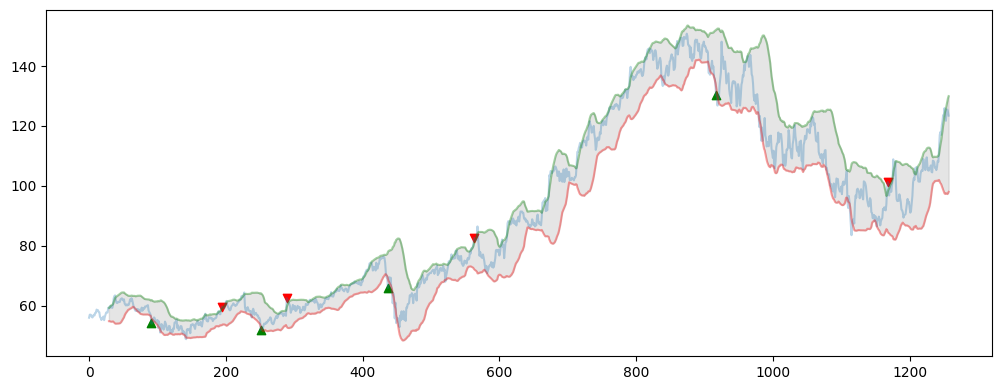

In [16]:
# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))

plt.plot(df['Close'], label='Close', alpha = 0.3)
plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
plt.show()

## Testing the strategy with S&P500 companies

In [17]:
from concurrent.futures import ThreadPoolExecutor

In [18]:
# create a dataframe to extract snp500 companies list
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_temp = pd.read_html(url)[0]
stock_list = df_temp['Symbol'].to_list()

Extract historical data from yfinance

In [19]:
stocks = yf.Tickers(stock_list).history(period="5y")

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
- HLT: No data found for this date range, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BKR: No data found for this date range, symbol may be delisted


Perform data cleansing

In [20]:
df2 = stocks.reset_index()['Close']
df2 = df2.dropna(axis=1, how='all')

Create loops with thread pool executor to concurrently run tickers extraction

In [21]:
def process_ticker(ticker):
    df = yf.Ticker(ticker).history(period="5y").reset_index()
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
    buy_price, sell_price = strategy(df)
    df['Buy'] = buy_price
    df['Sell'] = sell_price
    buy_signals = df['Buy'].dropna().reset_index(drop=True)
    sell_signals = df['Sell'].dropna().reset_index(drop=True)
    pnl = sell_signals - buy_signals
    accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()
    return ticker, accuracy, pnl.sum()

tickers = df2.columns

with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_ticker, tickers))

results_dict = {}
for ticker, accuracy, pnl in results:
    results_dict[ticker] = {'accuracy': accuracy, 'pnl': pnl}

/var/folders/gb/y91d_0014dlgwfxhcglf4drc0000gn/T/ipykernel_32360/1224187693.py:11: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()


/var/folders/gb/y91d_0014dlgwfxhcglf4drc0000gn/T/ipykernel_4000/1224187693.py:11: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()

Store the dictionary into dataframes for better visibilities

In [22]:
backtests = pd.DataFrame(results_dict).from_dict(results_dict, orient='index')
print(backtests)

      accuracy        pnl
A     0.960257  42.135475
AAL   0.228282  -7.808214
AAP   0.868762  22.983688
AAPL  1.000000  47.603058
ABBV  0.946477  67.670723
...        ...        ...
YUM   0.990837  21.334358
ZBH   0.775372  37.520668
ZBRA  0.562768  45.660049
ZION  0.724931  12.270237
ZTS   1.000000  84.508713

[499 rows x 2 columns]


## Overall strategy performance

Macro winning rate

In [23]:
gains = backtests['pnl'].where(backtests['pnl'] > 0, 0).sum()
loss = backtests['pnl'].where(backtests['pnl'] < 0, 0).sum()
win_ratio = gains / (gains + abs(loss))
print('Total PnL: ', backtests['pnl'].sum()
        , '\nTotal gains: ', gains, '\nTotal loss: ', loss)
print('Win ratio: ', win_ratio)

Total PnL:  24296.59463787079 
Total gains:  26774.15812587738 
Total loss:  -2477.563488006592
Win ratio:  0.9153019599765831


Plot out distribution in the strategy

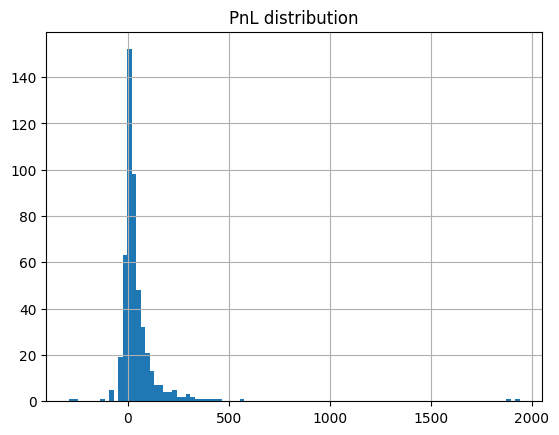

In [24]:
backtests['pnl'].hist(bins=100)
plt.title('PnL distribution')
plt.show()

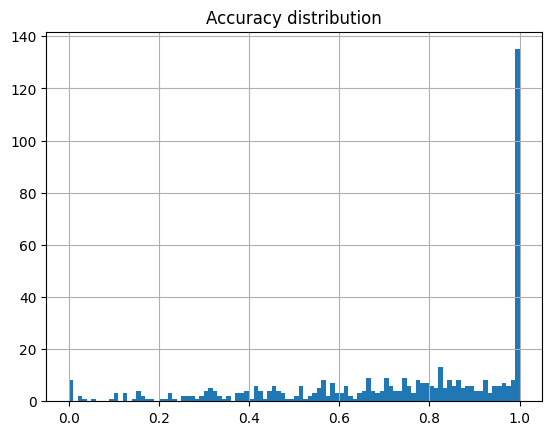

In [25]:
backtests['accuracy'].hist(bins=100)
plt.title('Accuracy distribution')
plt.show()

Find the most profitable stocks among this strategy

<Axes: >

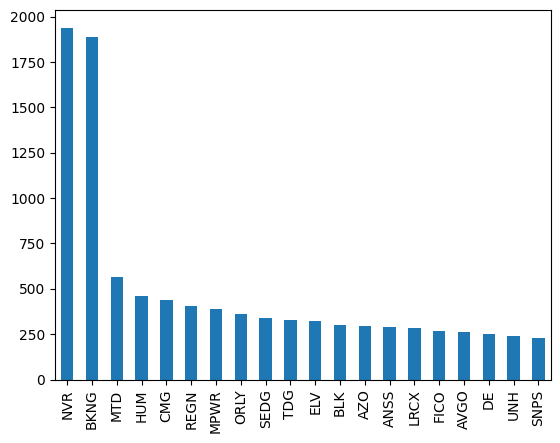

In [26]:
backtests['pnl'].sort_values(ascending=False).head(20).plot(kind='bar')

## Visualise the biggest gainers in the strategy

In [27]:
top_gainers = backtests.nlargest(5, 'pnl').index
print(top_gainers)

Index(['NVR', 'BKNG', 'MTD', 'HUM', 'CMG'], dtype='object')


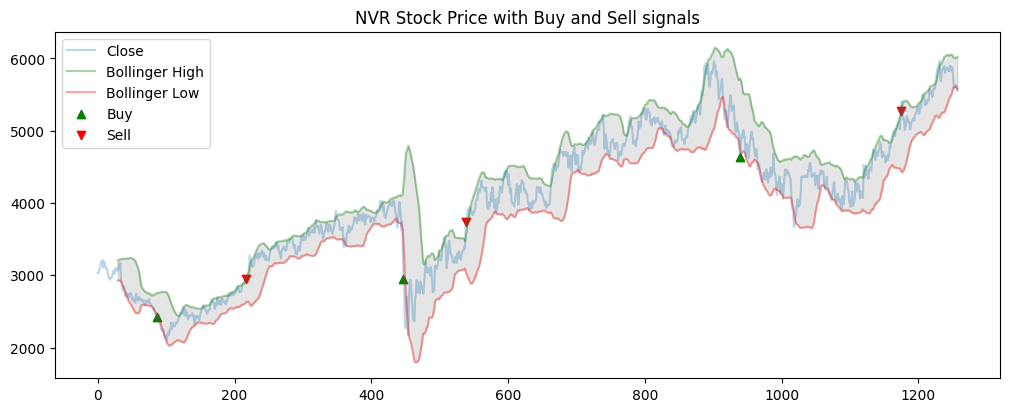

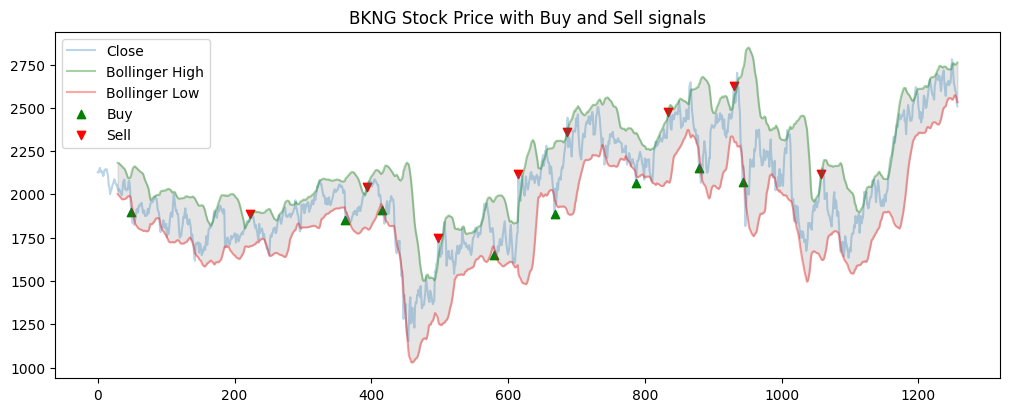

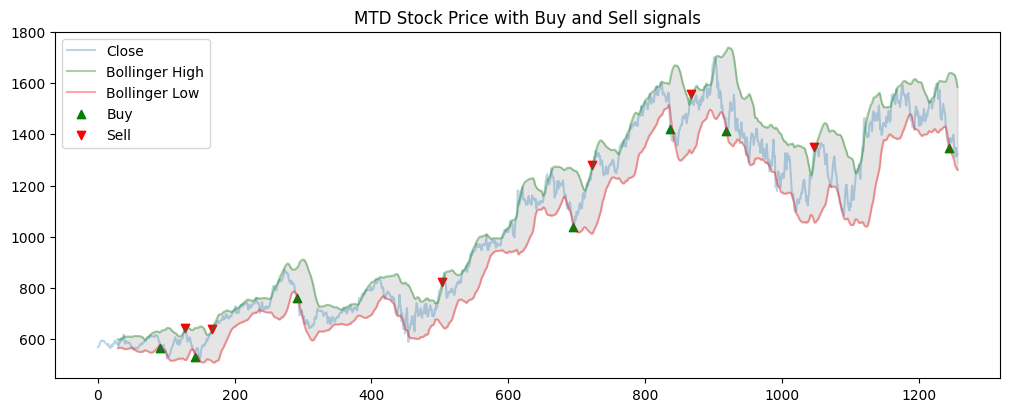

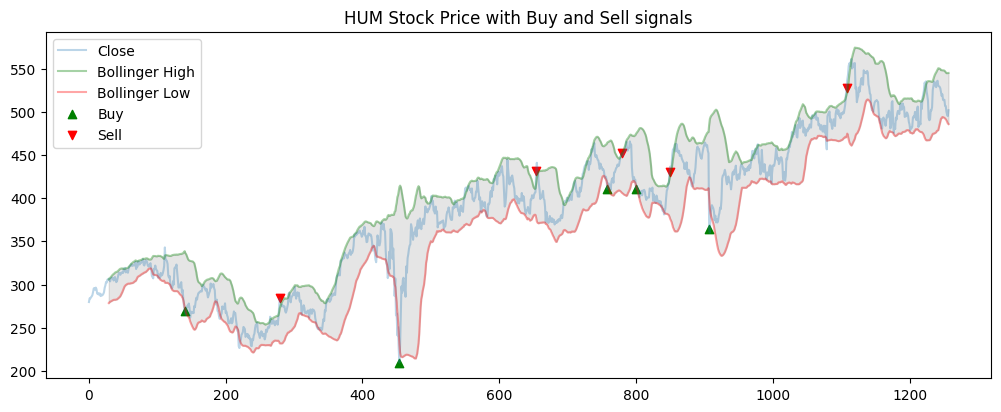

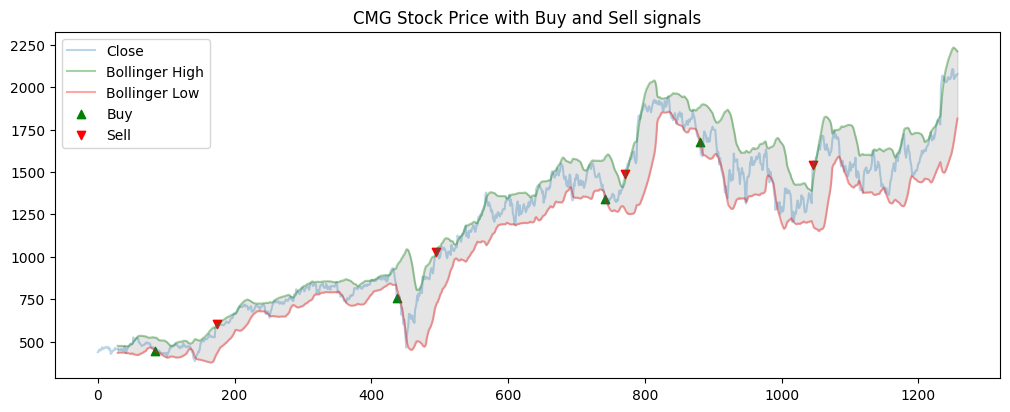

In [28]:
def plot_stock(ticker):
    df = yf.Ticker(ticker).history(period="5y").reset_index()
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
    buy_price, sell_price = strategy(df)
    df['Buy'] = buy_price
    df['Sell'] = sell_price
    plt.figure(figsize=(12.2, 4.5))
    plt.title(f'{ticker} Stock Price with Buy and Sell signals')
    plt.plot(df['Close'], label='Close', alpha=0.3)
    plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
    plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
    plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
    plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
    plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
    plt.legend(loc='best')
    plt.show()

# Plot the top 5 stocks
for ticker in top_gainers:
    plot_stock(ticker)